In [38]:
%matplotlib inline
import matplotlib
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from scipy import misc
from PIL import Image, ImageFilter
from scipy.ndimage.filters import gaussian_filter
from skimage.filters import *
from skimage.transform import *
import os
import math
from math import floor

In [39]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [40]:
def PS(T, r):
    T = np.transpose(T, (1, 2, 0))
    rW = r*len(T)
    rH = r*len(T[0])
    C = len(T[0][0])/(r*r)

    # make sure C is an integer and cast if this is the case
    assert(C == int(C))
    C = int(C)
    
    res = np.zeros((rW, rH, C))

    for x in range(len(res)):
        for y in range(len(res[x])):
            for c in range(len(res[x][y])):
                res[x][y][c] = \
                    T[x // r][y // r][C*r*(y % r) + C*(x % r) + c]
    return res

def PS_inv(img, r):
    r2 = r*r
    W = len(img)/r
    H = len(img[0])/r
    C = len(img[0][0])
    Cr2 = C*r2

    # Make sure H and W are integers
    assert(int(H) == H and int(W) == W)
    H, W = int(H), int(W)

    res = np.zeros((W, H, Cr2))

    for x in range(len(img)):
        for y in range(len(img[x])):
            for c in range(len(img[x][y])):
                res[x // r][y // r][C*r*(y % r) + C*(x % r) + c] = img[x][y][c]
    return res


In [41]:
# hyperparameters
r = 2 # upscaling ratio
blur = 1 # gaussian blur (missing ???)
C = 3 # colour channels
lr_start = 0.01 # learning rate
lr_end = 0.0001
u = 0.0001 # threshold for lowering the lr (missing ???)

(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)


(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)


(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)


(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)


(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)


(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)


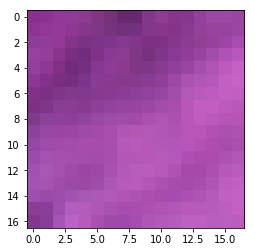

DONE!!!


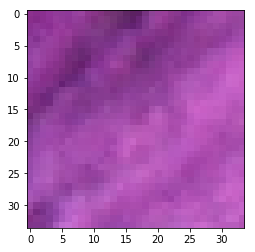

In [71]:
"""
Downsample images
- gaussian blur
- resize by downsample factor (using interpolation)

How To Use:
    function lr_dataset_from_path takes a path to the dataset of HR image png files and returns an ndarray to use for training the model
    
For debugging/showing examples:
    (see bottom of file)
    save_png set to True to save resulting lr images in specified directory.
    !check the param_ varaiables
"""

SUBSAMPLING_STRIDE_SIZE = 14
SUBSAMPLING_SAMPLE_SIZE = 17


# hr_dataset_path: dir to the hr_dataset png files
# downscale: downscale factor, e.g. if original image 64*64 and downscale=2 then result will be 32*32
# returns list of numpy.ndarray representing the lr_images
def lr_dataset_from_path(hr_dataset_path, downscale):
    original_filenames = os.listdir(hr_dataset_path)
    original_images = []
    for file in original_filenames:
        original_images.append(plt.imread(hr_dataset_path + '/' + file))
    return lr_images(original_images, downscale)  # ndarray of images


def torchDataloader_from_path(hr_dataset_path, downscale, gaussian_sigma):
    original_filenames = os.listdir(hr_dataset_path)
    original_images = []
    for file in original_filenames:
        original_images.append(plt.imread(hr_dataset_path + '/' + file))

    # subsample
    subsamples_hr = []
    subsamples_hr_rev_shuff = []
    for i in range(len(original_images)):
        temp_subsamples = subsample(original_images[i], downscale)
        subsamples_hr += temp_subsamples
        for sample_indx in range(len(temp_subsamples)):
            subsamples_hr_rev_shuff.append(PS_inv(temp_subsamples[sample_indx], downscale))  # labels
    lr_dataset = lr_images(subsamples_hr, downscale, gaussian_sigma)  # ndarray of images

    return toDataloader(lr_dataset, subsamples_hr_rev_shuff)


# Takes list of images and provide LR images in form of numpy array
def lr_images(images_real, downscale, gaussianSigma):
    lr_images = []
    for img in range(len(images_real)):
        img_blurred = gaussian(images_real[img], sigma=gaussianSigma,
                               multichannel=True)  # multichannel blurr so that 3rd channel is not blurred
        lr_images.append(resize(img_blurred, (img_blurred.shape[0] // downscale, img_blurred.shape[1] // downscale)))
    return lr_images


# extract a 17r*17r subsample from original image, no overlap so every pixel appears at most once in output
def subsample(image_real, downscale):
    subsample_size = SUBSAMPLING_SAMPLE_SIZE * downscale
    subsample_stride = SUBSAMPLING_STRIDE_SIZE * downscale
    subsamples = []
    for y in range(math.floor((image_real.shape[0] - (subsample_size - subsample_stride)) / subsample_stride)):
        for x in range(math.floor((image_real.shape[1] - (subsample_size - subsample_stride)) / subsample_stride)):
            ss = image_real[(y * subsample_stride):(y * subsample_stride) + subsample_size,
                 (x * subsample_stride):(x * subsample_stride) + subsample_size]
            subsamples.append(ss)

    return subsamples


# returns a torch Dataloader (to iterate over training data) using the training data samples and traing data labels
def toDataloader(train_data, train_labels):
    labeled_data = []
    for i in range(len(train_data)):
        print(train_data[i].shape)
        print(train_labels[i].shape)
        labeled_data.append([np.transpose(train_data[i], (2, 0, 1)), np.transpose(train_labels[i], (2, 0, 1))])
    trainDataloader = DataLoader(labeled_data)
    return trainDataloader


# ---DEBUG--- uncomment to show first image
# pyplot.imshow(original_images[0])
# pyplot.imshow(lr_dataset[0])

# ----TEST DATALOADER ----
dataloader = torchDataloader_from_path('datasets/T91', r, blur)

print("TESTIng datalaoder iter")
i1, l1 = next(iter(dataloader))
imshow(i1[0])
plt.imshow(PS(l1[0], r))

print("DONE!!!")

In [72]:
use_gpu = torch.cuda.is_available()

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(C, 64, 5, padding=2)
        self.conv2 = nn.Conv2d(64, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, r*r*C, 3, padding=1)

    def forward(self, x):
        x = torch.tanh(self.conv1(x))
        x = torch.tanh(self.conv2(x))
        x = self.conv3(x)
        return x


net = Net()
net.double()

if use_gpu:
    net = net.cuda()

In [73]:
# define loss fuction
criterion = nn.MSELoss()
optimizer = optim.SGD(net.parameters(), lr=lr_start, momentum=0.9) # momentum???
# scheduler = ReduceLROnPlateau(optimizer=optimizer, mode='min', threshold=u, min_lr=lr_end)

In [74]:
losses = []

for epoch in range(20):  # loop over the dataset multiple times
    epoch_loss = 0.0
    running_loss = 0.0
    for i, data in enumerate(dataloader, 0):
        # get the inputs
        inputs, labels = data
        if use_gpu:
            inputs = inputs.cuda()
            labels = labels.cuda()
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs.double())
        loss = criterion(outputs, labels)
        loss.backward()
#         sceduler.step()
        optimizer.step()

        # print statistics
        epoch_loss += outputs.shape[0] * loss.item()
        running_loss += loss.item()
        if i % 10 == 9:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.5f' %
                  (epoch + 1, i + 1, running_loss / 10))
            running_loss = 0.0
    print(epoch+1, epoch_loss / len(inputs))    
    losses.append(epoch_loss / len(inputs))
        

print('Finished Training')

[1,    10] loss: 0.17529
[1,    20] loss: 0.06165
[1,    30] loss: 0.04199
[1,    40] loss: 0.04982
[1,    50] loss: 0.05428
[1,    60] loss: 0.03958
[1,    70] loss: 0.03468
[1,    80] loss: 0.03071
[1,    90] loss: 0.02249
[1,   100] loss: 0.01246
[1,   110] loss: 0.04296
[1,   120] loss: 0.03224
[1,   130] loss: 0.02248
[1,   140] loss: 0.01562
[1,   150] loss: 0.03287
[1,   160] loss: 0.01256
[1,   170] loss: 0.01157
[1,   180] loss: 0.01005
[1,   190] loss: 0.02160
[1,   200] loss: 0.01861
[1,   210] loss: 0.02511
[1,   220] loss: 0.02565
[1,   230] loss: 0.01439
[1,   240] loss: 0.01082
[1,   250] loss: 0.01763
[1,   260] loss: 0.01179
[1,   270] loss: 0.01107
[1,   280] loss: 0.01156
[1,   290] loss: 0.01617
[1,   300] loss: 0.01122
[1,   310] loss: 0.01022
[1,   320] loss: 0.01046
[1,   330] loss: 0.01126
[1,   340] loss: 0.01138
[1,   350] loss: 0.01073
[1,   360] loss: 0.01418
[1,   370] loss: 0.02928
[1,   380] loss: 0.01548
[1,   390] loss: 0.01230
[1,   400] loss: 0.00755


[2,  1400] loss: 0.00996
[2,  1410] loss: 0.00752
[2,  1420] loss: 0.00794
[2,  1430] loss: 0.00378
[2,  1440] loss: 0.00547
[2,  1450] loss: 0.00376
[2,  1460] loss: 0.00368
[2,  1470] loss: 0.00400
[2,  1480] loss: 0.00337
[2,  1490] loss: 0.00315
[2,  1500] loss: 0.00265
[2,  1510] loss: 0.00288
[2,  1520] loss: 0.00350
[2,  1530] loss: 0.00230
[2,  1540] loss: 0.00348
[2,  1550] loss: 0.00222
[2,  1560] loss: 0.00203
[2,  1570] loss: 0.00265
[2,  1580] loss: 0.00285
[2,  1590] loss: 0.00289
[2,  1600] loss: 0.00214
[2,  1610] loss: 0.00482
[2,  1620] loss: 0.00385
[2,  1630] loss: 0.00469
[2,  1640] loss: 0.00323
[2,  1650] loss: 0.00143
[2,  1660] loss: 0.00136
[2,  1670] loss: 0.00153
[2,  1680] loss: 0.00147
[2,  1690] loss: 0.00176
[2,  1700] loss: 0.00143
[2,  1710] loss: 0.00150
[2,  1720] loss: 0.00159
[2,  1730] loss: 0.00185
[2,  1740] loss: 0.00188
[2,  1750] loss: 0.00285
[2,  1760] loss: 0.00248
[2,  1770] loss: 0.00601
[2,  1780] loss: 0.00873
[2,  1790] loss: 0.00907


[4,   920] loss: 0.00393
[4,   930] loss: 0.00333
[4,   940] loss: 0.00258
[4,   950] loss: 0.00287
[4,   960] loss: 0.00125
[4,   970] loss: 0.00100
[4,   980] loss: 0.00100
[4,   990] loss: 0.00089
[4,  1000] loss: 0.00110
[4,  1010] loss: 0.00115
[4,  1020] loss: 0.00139
[4,  1030] loss: 0.00179
[4,  1040] loss: 0.00204
[4,  1050] loss: 0.00157
[4,  1060] loss: 0.00202
[4,  1070] loss: 0.00138
[4,  1080] loss: 0.00109
[4,  1090] loss: 0.00086
[4,  1100] loss: 0.00144
[4,  1110] loss: 0.00248
[4,  1120] loss: 0.00323
[4,  1130] loss: 0.00348
[4,  1140] loss: 0.00379
[4,  1150] loss: 0.00305
[4,  1160] loss: 0.00317
[4,  1170] loss: 0.00354
[4,  1180] loss: 0.00309
[4,  1190] loss: 0.00308
[4,  1200] loss: 0.00315
[4,  1210] loss: 0.00331
[4,  1220] loss: 0.00185
[4,  1230] loss: 0.00120
[4,  1240] loss: 0.00095
[4,  1250] loss: 0.00115
[4,  1260] loss: 0.00092
[4,  1270] loss: 0.00088
[4,  1280] loss: 0.00092
[4,  1290] loss: 0.00168
[4,  1300] loss: 0.00190
[4,  1310] loss: 0.00112


[6,   440] loss: 0.00120
[6,   450] loss: 0.00097
[6,   460] loss: 0.00146
[6,   470] loss: 0.00256
[6,   480] loss: 0.00545
[6,   490] loss: 0.00628
[6,   500] loss: 0.00472
[6,   510] loss: 0.00404
[6,   520] loss: 0.00428
[6,   530] loss: 0.00189
[6,   540] loss: 0.00115
[6,   550] loss: 0.00495
[6,   560] loss: 0.00532
[6,   570] loss: 0.00524
[6,   580] loss: 0.00330
[6,   590] loss: 0.00060
[6,   600] loss: 0.00080
[6,   610] loss: 0.00105
[6,   620] loss: 0.00225
[6,   630] loss: 0.00221
[6,   640] loss: 0.00170
[6,   650] loss: 0.00192
[6,   660] loss: 0.00229
[6,   670] loss: 0.00280
[6,   680] loss: 0.00275
[6,   690] loss: 0.00121
[6,   700] loss: 0.00136
[6,   710] loss: 0.00171
[6,   720] loss: 0.00230
[6,   730] loss: 0.00064
[6,   740] loss: 0.00067
[6,   750] loss: 0.00132
[6,   760] loss: 0.00174
[6,   770] loss: 0.00184
[6,   780] loss: 0.00178
[6,   790] loss: 0.00162
[6,   800] loss: 0.00486
[6,   810] loss: 0.00499
[6,   820] loss: 0.00520
[6,   830] loss: 0.00370


[7,  1830] loss: 0.00393
[7,  1840] loss: 0.00612
[7,  1850] loss: 0.00707
[7,  1860] loss: 0.00681
[7,  1870] loss: 0.00139
7 3.7108870416681414
[8,    10] loss: 0.00101
[8,    20] loss: 0.00178
[8,    30] loss: 0.00117
[8,    40] loss: 0.00430
[8,    50] loss: 0.00846
[8,    60] loss: 0.00489
[8,    70] loss: 0.00408
[8,    80] loss: 0.00384
[8,    90] loss: 0.00383
[8,   100] loss: 0.00196
[8,   110] loss: 0.00096
[8,   120] loss: 0.00109
[8,   130] loss: 0.00095
[8,   140] loss: 0.00084
[8,   150] loss: 0.00032
[8,   160] loss: 0.00021
[8,   170] loss: 0.00039
[8,   180] loss: 0.00085
[8,   190] loss: 0.00131
[8,   200] loss: 0.00150
[8,   210] loss: 0.00158
[8,   220] loss: 0.00136
[8,   230] loss: 0.00101
[8,   240] loss: 0.00094
[8,   250] loss: 0.00247
[8,   260] loss: 0.00158
[8,   270] loss: 0.00266
[8,   280] loss: 0.00301
[8,   290] loss: 0.00150
[8,   300] loss: 0.00144
[8,   310] loss: 0.00188
[8,   320] loss: 0.00114
[8,   330] loss: 0.00157
[8,   340] loss: 0.00190
[8, 

[9,  1350] loss: 0.00093
[9,  1360] loss: 0.00108
[9,  1370] loss: 0.00067
[9,  1380] loss: 0.00102
[9,  1390] loss: 0.00438
[9,  1400] loss: 0.00524
[9,  1410] loss: 0.00361
[9,  1420] loss: 0.00409
[9,  1430] loss: 0.00086
[9,  1440] loss: 0.00261
[9,  1450] loss: 0.00125
[9,  1460] loss: 0.00162
[9,  1470] loss: 0.00167
[9,  1480] loss: 0.00141
[9,  1490] loss: 0.00143
[9,  1500] loss: 0.00097
[9,  1510] loss: 0.00122
[9,  1520] loss: 0.00137
[9,  1530] loss: 0.00068
[9,  1540] loss: 0.00156
[9,  1550] loss: 0.00079
[9,  1560] loss: 0.00077
[9,  1570] loss: 0.00100
[9,  1580] loss: 0.00119
[9,  1590] loss: 0.00130
[9,  1600] loss: 0.00085
[9,  1610] loss: 0.00192
[9,  1620] loss: 0.00153
[9,  1630] loss: 0.00235
[9,  1640] loss: 0.00137
[9,  1650] loss: 0.00054
[9,  1660] loss: 0.00038
[9,  1670] loss: 0.00048
[9,  1680] loss: 0.00045
[9,  1690] loss: 0.00073
[9,  1700] loss: 0.00059
[9,  1710] loss: 0.00061
[9,  1720] loss: 0.00062
[9,  1730] loss: 0.00078
[9,  1740] loss: 0.00061


[11,   760] loss: 0.00126
[11,   770] loss: 0.00139
[11,   780] loss: 0.00137
[11,   790] loss: 0.00126
[11,   800] loss: 0.00355
[11,   810] loss: 0.00368
[11,   820] loss: 0.00374
[11,   830] loss: 0.00267
[11,   840] loss: 0.00168
[11,   850] loss: 0.00237
[11,   860] loss: 0.00226
[11,   870] loss: 0.00266
[11,   880] loss: 0.00310
[11,   890] loss: 0.00239
[11,   900] loss: 0.00305
[11,   910] loss: 0.00297
[11,   920] loss: 0.00291
[11,   930] loss: 0.00245
[11,   940] loss: 0.00182
[11,   950] loss: 0.00200
[11,   960] loss: 0.00060
[11,   970] loss: 0.00037
[11,   980] loss: 0.00040
[11,   990] loss: 0.00036
[11,  1000] loss: 0.00051
[11,  1010] loss: 0.00056
[11,  1020] loss: 0.00076
[11,  1030] loss: 0.00110
[11,  1040] loss: 0.00135
[11,  1050] loss: 0.00098
[11,  1060] loss: 0.00131
[11,  1070] loss: 0.00084
[11,  1080] loss: 0.00064
[11,  1090] loss: 0.00051
[11,  1100] loss: 0.00086
[11,  1110] loss: 0.00154
[11,  1120] loss: 0.00205
[11,  1130] loss: 0.00233
[11,  1140] 

[13,   150] loss: 0.00021
[13,   160] loss: 0.00013
[13,   170] loss: 0.00028
[13,   180] loss: 0.00070
[13,   190] loss: 0.00103
[13,   200] loss: 0.00114
[13,   210] loss: 0.00124
[13,   220] loss: 0.00099
[13,   230] loss: 0.00072
[13,   240] loss: 0.00074
[13,   250] loss: 0.00216
[13,   260] loss: 0.00136
[13,   270] loss: 0.00230
[13,   280] loss: 0.00262
[13,   290] loss: 0.00124
[13,   300] loss: 0.00114
[13,   310] loss: 0.00156
[13,   320] loss: 0.00087
[13,   330] loss: 0.00120
[13,   340] loss: 0.00156
[13,   350] loss: 0.00161
[13,   360] loss: 0.00096
[13,   370] loss: 0.00060
[13,   380] loss: 0.00064
[13,   390] loss: 0.00036
[13,   400] loss: 0.00045
[13,   410] loss: 0.00057
[13,   420] loss: 0.00042
[13,   430] loss: 0.00042
[13,   440] loss: 0.00077
[13,   450] loss: 0.00056
[13,   460] loss: 0.00097
[13,   470] loss: 0.00185
[13,   480] loss: 0.00413
[13,   490] loss: 0.00472
[13,   500] loss: 0.00353
[13,   510] loss: 0.00310
[13,   520] loss: 0.00325
[13,   530] 

[14,  1420] loss: 0.00368
[14,  1430] loss: 0.00073
[14,  1440] loss: 0.00230
[14,  1450] loss: 0.00105
[14,  1460] loss: 0.00144
[14,  1470] loss: 0.00141
[14,  1480] loss: 0.00121
[14,  1490] loss: 0.00120
[14,  1500] loss: 0.00079
[14,  1510] loss: 0.00100
[14,  1520] loss: 0.00110
[14,  1530] loss: 0.00051
[14,  1540] loss: 0.00127
[14,  1550] loss: 0.00066
[14,  1560] loss: 0.00062
[14,  1570] loss: 0.00080
[14,  1580] loss: 0.00100
[14,  1590] loss: 0.00109
[14,  1600] loss: 0.00070
[14,  1610] loss: 0.00160
[14,  1620] loss: 0.00128
[14,  1630] loss: 0.00195
[14,  1640] loss: 0.00117
[14,  1650] loss: 0.00046
[14,  1660] loss: 0.00030
[14,  1670] loss: 0.00038
[14,  1680] loss: 0.00035
[14,  1690] loss: 0.00062
[14,  1700] loss: 0.00049
[14,  1710] loss: 0.00051
[14,  1720] loss: 0.00051
[14,  1730] loss: 0.00065
[14,  1740] loss: 0.00051
[14,  1750] loss: 0.00066
[14,  1760] loss: 0.00062
[14,  1770] loss: 0.00199
[14,  1780] loss: 0.00244
[14,  1790] loss: 0.00270
[14,  1800] 

[16,   810] loss: 0.00315
[16,   820] loss: 0.00315
[16,   830] loss: 0.00232
[16,   840] loss: 0.00149
[16,   850] loss: 0.00215
[16,   860] loss: 0.00207
[16,   870] loss: 0.00239
[16,   880] loss: 0.00271
[16,   890] loss: 0.00218
[16,   900] loss: 0.00282
[16,   910] loss: 0.00275
[16,   920] loss: 0.00273
[16,   930] loss: 0.00229
[16,   940] loss: 0.00167
[16,   950] loss: 0.00183
[16,   960] loss: 0.00053
[16,   970] loss: 0.00030
[16,   980] loss: 0.00033
[16,   990] loss: 0.00030
[16,  1000] loss: 0.00043
[16,  1010] loss: 0.00047
[16,  1020] loss: 0.00066
[16,  1030] loss: 0.00098
[16,  1040] loss: 0.00122
[16,  1050] loss: 0.00087
[16,  1060] loss: 0.00117
[16,  1070] loss: 0.00075
[16,  1080] loss: 0.00057
[16,  1090] loss: 0.00045
[16,  1100] loss: 0.00075
[16,  1110] loss: 0.00137
[16,  1120] loss: 0.00182
[16,  1130] loss: 0.00210
[16,  1140] loss: 0.00229
[16,  1150] loss: 0.00163
[16,  1160] loss: 0.00188
[16,  1170] loss: 0.00216
[16,  1180] loss: 0.00179
[16,  1190] 

[18,   200] loss: 0.00100
[18,   210] loss: 0.00109
[18,   220] loss: 0.00080
[18,   230] loss: 0.00059
[18,   240] loss: 0.00066
[18,   250] loss: 0.00203
[18,   260] loss: 0.00127
[18,   270] loss: 0.00216
[18,   280] loss: 0.00246
[18,   290] loss: 0.00113
[18,   300] loss: 0.00101
[18,   310] loss: 0.00143
[18,   320] loss: 0.00073
[18,   330] loss: 0.00102
[18,   340] loss: 0.00141
[18,   350] loss: 0.00148
[18,   360] loss: 0.00080
[18,   370] loss: 0.00051
[18,   380] loss: 0.00055
[18,   390] loss: 0.00029
[18,   400] loss: 0.00039
[18,   410] loss: 0.00047
[18,   420] loss: 0.00033
[18,   430] loss: 0.00033
[18,   440] loss: 0.00068
[18,   450] loss: 0.00047
[18,   460] loss: 0.00088
[18,   470] loss: 0.00170
[18,   480] loss: 0.00382
[18,   490] loss: 0.00434
[18,   500] loss: 0.00323
[18,   510] loss: 0.00287
[18,   520] loss: 0.00299
[18,   530] loss: 0.00129
[18,   540] loss: 0.00075
[18,   550] loss: 0.00362
[18,   560] loss: 0.00380
[18,   570] loss: 0.00382
[18,   580] 

[19,  1470] loss: 0.00128
[19,  1480] loss: 0.00112
[19,  1490] loss: 0.00110
[19,  1500] loss: 0.00071
[19,  1510] loss: 0.00090
[19,  1520] loss: 0.00098
[19,  1530] loss: 0.00045
[19,  1540] loss: 0.00114
[19,  1550] loss: 0.00059
[19,  1560] loss: 0.00055
[19,  1570] loss: 0.00071
[19,  1580] loss: 0.00091
[19,  1590] loss: 0.00099
[19,  1600] loss: 0.00062
[19,  1610] loss: 0.00145
[19,  1620] loss: 0.00116
[19,  1630] loss: 0.00176
[19,  1640] loss: 0.00108
[19,  1650] loss: 0.00042
[19,  1660] loss: 0.00026
[19,  1670] loss: 0.00034
[19,  1680] loss: 0.00030
[19,  1690] loss: 0.00056
[19,  1700] loss: 0.00045
[19,  1710] loss: 0.00046
[19,  1720] loss: 0.00046
[19,  1730] loss: 0.00059
[19,  1740] loss: 0.00046
[19,  1750] loss: 0.00061
[19,  1760] loss: 0.00057
[19,  1770] loss: 0.00180
[19,  1780] loss: 0.00218
[19,  1790] loss: 0.00239
[19,  1800] loss: 0.00121
[19,  1810] loss: 0.00103
[19,  1820] loss: 0.00063
[19,  1830] loss: 0.00296
[19,  1840] loss: 0.00484
[19,  1850] 

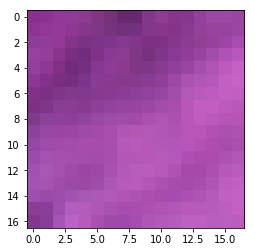

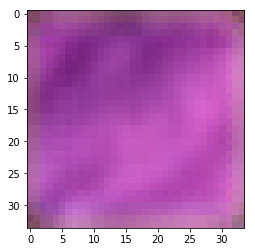

In [69]:
imshow(i1[0])
net.cpu()
result = net(i1.double()).detach().numpy()
net.cuda()
plt.imshow(PS(res, r))

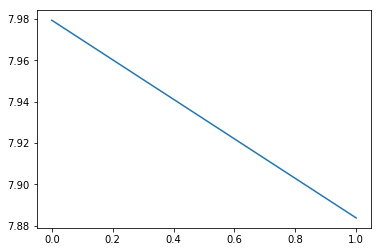

In [70]:
plt.plot(losses)